The empirical exercise should focus on how the sector and factor tilting works when a crisis comes, better diversification provided, consistent risk factor contributions, and greater resilience to economic shocks 

In [1]:
import os
from datetime import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import cvxpy as cp
from tqdm.notebook import tqdm
from regimeaware.routines import cfg
from itertools import product
from regimeaware.core import utils

rebalance_dts = pd.date_range(start=cfg.bt_start_dt, end=cfg.bt_end_dt, freq=cfg.rebalance_freq)

# Data
rt_ff = pd.read_pickle(f'{cfg.data_fldr}/ff.pkl')[cfg.factor_set]
crsp = pd.read_pickle(f'{cfg.data_fldr}/crsp.pkl')
rt = pd.pivot_table(crsp[['excess_ret']], index='date', columns='permno', values='excess_ret')

# Load cached factor estimates
factor_covars = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_covars.pkl')
factor_means = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_means.pkl')
factor_loadings = pd.read_pickle(f'{cfg.data_fldr}/exposures/forecasted_betas.pkl')
factor_variance = pd.read_pickle(f'{cfg.data_fldr}/exposures/var.pkl')

# Reference market cap weights
mktcap = crsp['mktcap'].copy()
ref_wts = mktcap.groupby('permno').shift(1).reindex(factor_loadings.index.droplevel('factor').unique())
ref_wts = ref_wts.div(ref_wts.groupby('date').sum())

bm = ref_wts.groupby('id').shift(1).mul(crsp['excess_ret'].reindex(ref_wts.index)).groupby('date').sum().add(1).cumprod()

$$
\begin{equation}
\begin{aligned}
& \underset{w}{\text{argmin}} & & \gamma \left( w^{T} F^{T} \Sigma_{f} F w + w^{T} E w \right) - w^{T} \mu_{f} \\
& \text{s.t.} & & (w - b)^{T} \Sigma (w - b) \leq \bar{\sigma}^{2} \\
& & & \sum_{i=1}^{N} w_i = 1 \\
& & &  w_i \geq 0 \; ; \; \forall \; i =1, \ldots, N \\
\end{aligned}
\end{equation}
$$

<Axes: xlabel='as_of'>

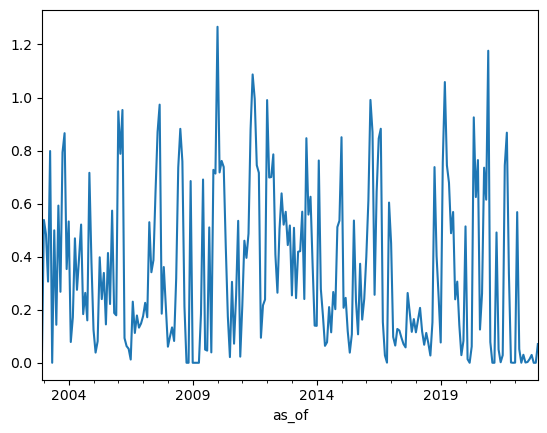

<Axes: xlabel='as_of'>

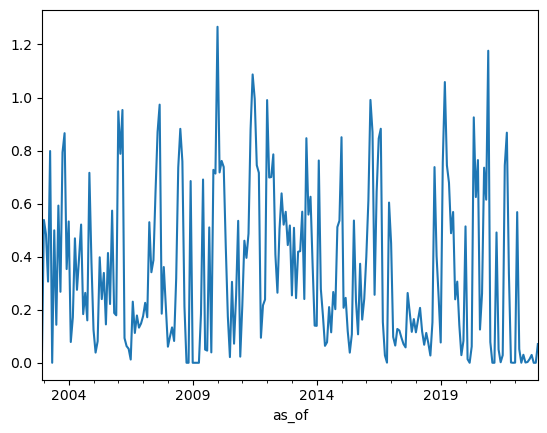

In [2]:
collect_w = {}

for g, t, dt in product(cfg.gamma_iter, cfg.tev_budget_iter, rebalance_dts):
    # Data handling
    sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
    mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
    mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
    Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
    F = utils.unpack_betas(factor_loadings.xs(dt)).reindex(sec_ids).values.T
    E = np.diag(factor_variance.xs(dt).reindex(sec_ids))
    b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
    b = np.divide(b, b.sum())

    # Optimization problem
    tev_budget = cp.Parameter(nonneg=True)
    gamma = cp.Parameter(nonneg=True)

    m, n = F.shape
    w = cp.Variable((n, 1))
    f = cp.Variable((m, 1))

    Sigma_f_const = np.zeros((m, m))
    Sigma_f_const[1:, 1:] = Sigma_f

    tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
    port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
    port_return = mu_f_const.T @ f

    constraints = [
        cp.sum(w) == 1,
        f == F @ w,
        w >= 0,
        tracking_error <= tev_budget 
    ]

    gamma.value = g
    tev_budget.value = (t / 12) ** 2 

    prob = cp.Problem(cp.Maximize(port_return - gamma * port_risk), constraints)
    prob.solve(verbose=False, solver=cp.CLARABEL)
    collect_w[(t, g, dt)] = pd.Series(w.value.flatten(), index=sec_ids)

wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)
wts.index.names = ['tev', 'gamma', 'date']

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

In [4]:
collect_bt = {}
for g, t in product(cfg.gamma_iter, cfg.tev_budget_iter):
    wt = wts.xs(t).xs(g)
    collect_bt[(g, t)] = wt.shift(1).mul(rt).dropna(how='all').sum(axis=1)

bt = pd.DataFrame.from_dict(collect_bt)
bt = bt.reindex(bm.index).fillna(0)
bt.columns = [f'Gamma: {x}\nTE Budget: {y * 100}' for x,y in bt.columns]

<Axes: xlabel='date'>

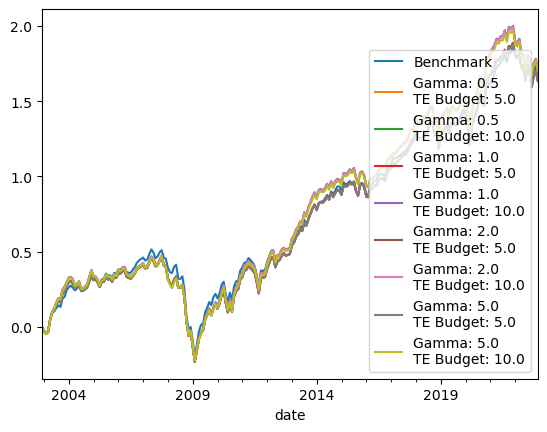

In [5]:
df = bm.to_frame(name='Benchmark').join(bt.add(1).cumprod())
df.apply(np.log).plot()

In [6]:
tracking = df.sub(df['Benchmark'], axis=0).drop('Benchmark', axis=1)
tracking.mean().div(tracking.std()).mul(np.sqrt(12)).sort_values()

Gamma: 5.0\nTE Budget: 5.0    -1.550748
Gamma: 2.0\nTE Budget: 5.0    -1.180415
Gamma: 1.0\nTE Budget: 5.0    -1.118083
Gamma: 0.5\nTE Budget: 5.0    -1.103885
Gamma: 5.0\nTE Budget: 10.0    1.908076
Gamma: 2.0\nTE Budget: 10.0    2.057078
Gamma: 0.5\nTE Budget: 10.0    2.071055
Gamma: 1.0\nTE Budget: 10.0    2.072218
dtype: float64

In [7]:
df.mean().div(df.std()).mul(np.sqrt(12)).sort_values()

Gamma: 0.5\nTE Budget: 10.0    5.380487
Gamma: 1.0\nTE Budget: 10.0    5.383893
Gamma: 2.0\nTE Budget: 10.0    5.392524
Gamma: 5.0\nTE Budget: 10.0    5.430958
Gamma: 0.5\nTE Budget: 5.0     5.736404
Gamma: 1.0\nTE Budget: 5.0     5.737169
Gamma: 2.0\nTE Budget: 5.0     5.740506
Gamma: 5.0\nTE Budget: 5.0     5.757963
Benchmark                      5.945814
dtype: float64

Obs
- Higher TEV-Budget leads to better IR
- Higher risk aversion leads to lower IR? 

<Axes: xlabel='as_of'>

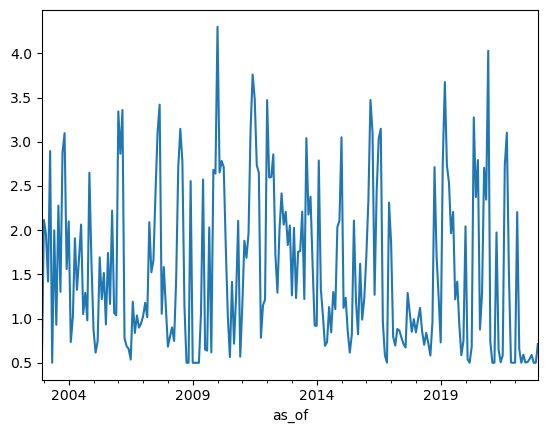

In [46]:
from scipy.stats import entropy

transmat = pd.read_pickle(f'{cfg.data_fldr}/regimes/transmat.pkl')
emission_prob = pd.read_pickle(f'{cfg.data_fldr}/regimes/emission_prob.pkl')
h = emission_prob.groupby('as_of').last().apply(entropy, axis=1)
h.mul(3).add(.5).plot()

In [58]:
collect_w = {}

# for t, dt in product(cfg.tev_budget_iter, rebalance_dts):
for t, dt in product([.01, .05, .1, .2, .3, .4, .5], rebalance_dts):
    # Data handling
    sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
    mu_f = factor_means.xs(dt)[cfg.factor_set].values.reshape(-1, 1)
    mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
    Sigma_f = factor_covars.xs(dt).loc[cfg.factor_set, cfg.factor_set].values
    F = utils.unpack_betas(factor_loadings.xs(dt)).reindex(sec_ids).values.T
    E = np.diag(factor_variance.xs(dt).reindex(sec_ids))
    b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
    b = np.divide(b, b.sum())

    # Optimization problem
    tev_budget = cp.Parameter(nonneg=True)
    gamma = cp.Parameter(nonneg=True)

    m, n = F.shape
    w = cp.Variable((n, 1))
    f = cp.Variable((m, 1))

    Sigma_f_const = np.zeros((m, m))
    Sigma_f_const[1:, 1:] = Sigma_f

    tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
    port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
    port_return = mu_f_const.T @ f

    constraints = [
        cp.sum(w) == 1,
        f == F @ w,
        w >= 0,
        tracking_error <= tev_budget 
    ]
    g = h.xs(dt) * 3 + .5  # <--------------------------------
    gamma.value = g
    tev_budget.value = (t / 12) ** 2 

    prob = cp.Problem(cp.Maximize(port_return - gamma * port_risk), constraints)
    prob.solve(verbose=False, solver=cp.CLARABEL)
    collect_w[(t, dt)] = pd.Series(w.value.flatten(), index=sec_ids)

wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)
wts.index.names = ['tev', 'date']

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

Gamma: x\nTE Budget: 1.0    -0.276179
Gamma: x\nTE Budget: 5.0    -0.088096
Gamma: x\nTE Budget: 10.0    0.062226
Gamma: x\nTE Budget: 40.0    0.105746
Gamma: x\nTE Budget: 50.0    0.108063
Gamma: x\nTE Budget: 30.0    0.128641
Gamma: x\nTE Budget: 20.0    0.134561
dtype: float64

Gamma: x\nTE Budget: 50.0    0.510760
Gamma: x\nTE Budget: 40.0    0.536315
Gamma: x\nTE Budget: 30.0    0.579803
Gamma: x\nTE Budget: 20.0    0.616167
Gamma: x\nTE Budget: 5.0     0.625791
Gamma: x\nTE Budget: 10.0    0.631413
Gamma: x\nTE Budget: 1.0     0.632435
Benchmark                    0.635878
dtype: float64

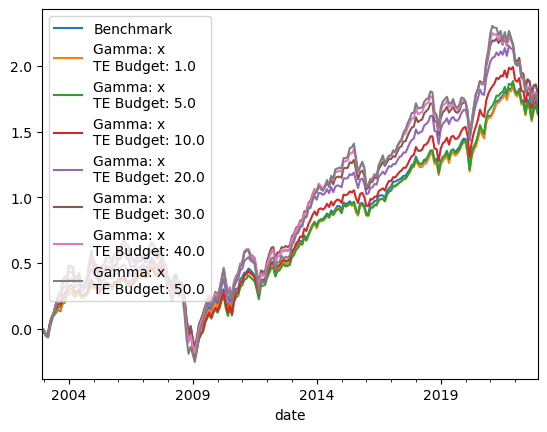

In [63]:
collect_bt = {}
# for t in cfg.tev_budget_iter:
for t in [.01, .05, .1, .2, .3, .4, .5]:
    wt = wts.xs(t)
    collect_bt[t] = wt.shift(1).mul(rt).dropna(how='all').sum(axis=1)

bt = pd.DataFrame.from_dict(collect_bt)
bt = bt.reindex(bm.index).fillna(0)
bt.columns = [f'Gamma: x\nTE Budget: {x * 100}' for x in bt.columns]

df = bm.to_frame(name='Benchmark').join(bt.add(1).cumprod())
df.apply(np.log).plot()

tracking = df.pct_change().sub(df['Benchmark'].pct_change(), axis=0).drop('Benchmark', axis=1)
display((tracking.mean() / tracking.std() * np.sqrt(12)).sort_values())

display((df.pct_change().mean() / df.pct_change().std() * np.sqrt(12)).sort_values())

In [ ]:
"""
MVO is giving issues because the matrix is not invertible
When I do dropna gives me back two obervations, which should be wrong, as the tradabale securities have betas, and to have a beta we require 10 years of obervations (120 obs)
For this reason, I'd expect each stock to have the last 120 obs valid

Confirmed, the matrix is not invertible and that was causing the issues while optimizing

Compared to: Historical beta estimation
"""

In [65]:
collect_w = {}

for window in cfg.ols_windows:
    factor_loadings_ols = pd.read_pickle(f'{cfg.data_fldr}/exposures/ols_betas_{window}.pkl')
    factor_variance_ols = pd.read_pickle(f'{cfg.data_fldr}/exposures/ols_var_{window}.pkl')
    for g in cfg.gamma_iter:
        for t in cfg.tev_budget_iter:
            for dt in tqdm(rebalance_dts, desc=f'window: {window}, gamma: {g}, te budget: {t * 100}%'):
                # Data handling
                sec_ids = ref_wts.xs(dt).index # This has to be changes to a cached 'is_tradable' flag
                
                factor_sample = rt_ff.loc[cfg.trn_start_dt:dt, cfg.factor_set].iloc[-window:]
                mu_f = factor_sample.mean().values.reshape(-1, 1)
                mu_f_const = np.concatenate([np.array([[1]]), mu_f], axis=0)  # Adding back the constant
                Sigma_f = factor_sample.cov().values
                
                
                F = utils.unpack_betas(factor_loadings_ols.xs(dt)).reindex(sec_ids).values.T
                E = np.diag(factor_variance_ols.xs(dt).reindex(sec_ids))
                b = mktcap.xs(dt).reindex(sec_ids).values.reshape(-1, 1)
                b = np.divide(b, b.sum())

                # Optimization problem
                tev_budget = cp.Parameter(nonneg=True)
                gamma = cp.Parameter(nonneg=True)

                m, n = F.shape
                w = cp.Variable((n, 1))
                f = cp.Variable((m, 1))

                Sigma_f_const = np.zeros((m, m))
                Sigma_f_const[1:, 1:] = Sigma_f

                tracking_error = cp.quad_form(F @ (w - b), Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ (w - b))
                port_risk = cp.quad_form(f, Sigma_f_const) + cp.sum_squares(np.sqrt(E) @ w)  # TODO: test with quadform
                port_return = mu_f_const.T @ f

                constraints = [
                    cp.sum(w) == 1,
                    f == F @ w,
                    w >= 0,
                    tracking_error <= tev_budget 
                ]

                gamma.value = g
                tev_budget.value = (t / 12) ** 2 

                prob = cp.Problem(cp.Maximize(port_return - gamma * port_risk), constraints)
                prob.solve(verbose=False, solver=cp.CLARABEL)
                collect_w[(window, t, g, dt)] = pd.Series(w.value.flatten(), index=sec_ids)


window: 36, gamma: 0.5, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

window: 36, gamma: 0.5, te budget: 10.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

window: 36, gamma: 1, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

window: 36, gamma: 1, te budget: 10.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

window: 36, gamma: 2, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

window: 36, gamma: 2, te budget: 10.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

window: 36, gamma: 5, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

window: 36, gamma: 5, te budget: 10.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

window: 60, gamma: 0.5, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

window: 60, gamma: 0.5, te budget: 10.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


window: 60, gamma: 1, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

window: 60, gamma: 1, te budget: 10.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

window: 60, gamma: 2, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

window: 60, gamma: 2, te budget: 10.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

window: 60, gamma: 5, te budget: 5.0%:   0%|          | 0/241 [00:00<?, ?it/s]

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users

KeyboardInterrupt: 

In [67]:
wts

49154.0       65541.0       40970.0  \
36 0.05 0.5 2002-12-31  2.206533e-04  1.150390e-13  1.066019e-14   
            2003-01-31  1.507302e-08  1.593722e-09  1.230942e-10   
            2003-02-28  2.007346e-05  1.325556e-08  6.274425e-10   
            2003-03-31  2.105593e-09  7.628373e-10  1.968225e-10   
            2003-04-30  4.295149e-04  1.710671e-09  6.776811e-10   
...                              ...           ...           ...   
60 0.05 5.0 2016-08-31  3.949310e-09  9.227336e-08  0.000000e+00   
            2016-09-30  4.970923e-09  1.314242e-08  0.000000e+00   
            2016-10-31  3.140071e-09  1.691057e-08  0.000000e+00   
            2016-11-30  6.823218e-11  3.020958e-10  0.000000e+00   
            2016-12-31  1.335793e-11  2.285712e-11  0.000000e+00   

                             16417.0       32803.0       16424.0  \
36 0.05 0.5 2002-12-31  5.710194e-14  1.294031e-03  6.286441e-14   
            2003-01-31  7.723593e-10  1.327785e-03  1.000697e-09   
            2003-02-28  3.161182e-09  1.778405e-03  4.167823e-09   
            2003-03-31  1.246717e-09  2.377009e-03  6.365286e-10   
            2003-04-30  7.097288e-09  2.355488e-03  1.909249e-09   
...                              ...           ...           ...   
60 0.05 5.0 2016-08-31  1.697973e-09  2.076462e-09  0.000000e+00   
            2016-09-30  2.053413e-09  3.341463e-09  0.000000e+00   
            2016-10-31  1.254058e-09  2.122259e-09  0.000000e+00   
            2016-11-30  1.802938e-11  6.608184e-11  0.000000e+00   
            2016-12-31  3.887598e-12  3.961303e-11  0.000000e+00   

                             16432.0       65584.0       24628.0  \
36 0.05 0.5 2002-12-31  3.058421e-14  9.058324e-14  7.504219e-14   
            2003-01-31  3.574582e-10  1.242300e-09  1.035144e-09   
            2003-02-28  1.076889e-09  4.048238e-09  3.685697e-09   
            2003-03-31  3.034434e-10  7.071514e-10  4.209660e-10   
            2003-04-30  7.906763e-10  2.409941e-09  2.088703e-09   
...                              ...           ...           ...   
60 0.05 5.0 2016-08-31  2.644191e-09  0.000000e+00  0.000000e+00   
            2016-09-30  4.200952e-09  0.000000e+00  0.000000e+00   
            2016-10-31  1.671379e-09  0.000000e+00  0.000000e+00   
            2016-11-30  2.161712e-11  0.000000e+00  0.000000e+00   
            2016-12-31  4.987953e-12  0.000000e+00  0.000000e+00   

                             24643.0  ...  13643.0  13648.0  13652.0  13687.0  \
36 0.05 0.5 2002-12-31  8.879663e-14  ...      0.0      0.0      0.0      0.0   
            2003-01-31  1.073472e-09  ...      0.0      0.0      0.0      0.0   
            2003-02-28  5.020122e-09  ...      0.0      0.0      0.0      0.0   
            2003-03-31  1.174457e-09  ...      0.0      0.0      0.0      0.0   
            2003-04-30  1.638853e-08  ...      0.0      0.0      0.0      0.0   
...                              ...  ...      ...      ...      ...      ...   
60 0.05 5.0 2016-08-31  1.387968e-09  ...      0.0      0.0      0.0      0.0   
            2016-09-30  2.168551e-09  ...      0.0      0.0      0.0      0.0   
            2016-10-31  1.179107e-09  ...      0.0      0.0      0.0      0.0   
            2016-11-30  1.392523e-11  ...      0.0      0.0      0.0      0.0   
            2016-12-31  3.674580e-12  ...      0.0      0.0      0.0      0.0   

                        13693.0  13694.0  13455.0  13704.0  13712.0  13730.0  
36 0.05 0.5 2002-12-31      0.0      0.0      0.0      0.0      0.0      0.0  
            2003-01-31      0.0      0.0      0.0      0.0      0.0      0.0  
            2003-02-28      0.0      0.0      0.0      0.0      0.0      0.0  
            2003-03-31      0.0      0.0      0.0      0.0      0.0      0.0  
            2003-04-30      0.0      0.0      0.0      0.0      0.0      0.0  
...                         ...      ...      ...      ...      ...      ...  
60 0.05 5.0 2016-08-31      0.0      0.0      0.0   

In [70]:
g

5

In [69]:
wts.xs(w).xs(t)

49154.0       65541.0       40970.0       16417.0  \
0.5 2002-12-31  1.715360e-03  1.548653e-10 -1.210244e-12  7.897887e-11   
    2003-01-31  2.249132e-08  2.027570e-10 -1.741221e-12  1.364025e-10   
    2003-02-28  4.592693e-04  6.611759e-10  5.302265e-12  3.367079e-10   
    2003-03-31  2.230017e-09  2.199342e-10  7.420730e-12  1.151934e-10   
    2003-04-30  8.708927e-04  3.997590e-10  1.148250e-11  2.276559e-10   
...                      ...           ...           ...           ...   
2.0 2022-08-31  2.610956e-03  7.443994e-10  0.000000e+00  0.000000e+00   
    2022-09-30  2.297513e-03  6.735318e-10  0.000000e+00  0.000000e+00   
    2022-10-31  3.826496e-03  1.117763e-10  0.000000e+00  0.000000e+00   
    2022-11-30  3.750478e-03  2.891897e-10  0.000000e+00  0.000000e+00   
    2022-12-31  5.177940e-04  2.091257e-09  0.000000e+00  0.000000e+00   

                     32803.0       16424.0       16432.0       65584.0  \
0.5 2002-12-31  2.172919e-10  1.148086e-10  2.953299e-11  1.507192e-10   
    2003-01-31  3.883201e-10  2.166921e-10  4.380625e-11  3.013589e-10   
    2003-02-28  1.040193e-09  4.869795e-10  7.426149e-11  6.762755e-10   
    2003-03-31  6.511859e-10  1.201158e-10  2.449174e-11  1.976083e-10   
    2003-04-30  6.108614e-10  2.046080e-10  5.023420e-11  3.801208e-10   
...                      ...           ...           ...           ...   
2.0 2022-08-31  1.581945e-09  0.000000e+00  3.864013e-10  0.000000e+00   
    2022-09-30  1.940196e-09  0.000000e+00  2.771114e-10  0.000000e+00   
    2022-10-31  2.727061e-10  0.000000e+00  5.670838e-11  0.000000e+00   
    2022-11-30  3.771825e-10  0.000000e+00  9.581907e-11  0.000000e+00   
    2022-12-31  1.197939e-09  0.000000e+00  4.574859e-10  0.000000e+00   

                     24628.0       24643.0  ...       13643.0       13648.0  \
0.5 2002-12-31  8.945761e-11  3.044061e-10  ...  0.000000e+00  0.000000e+00   
    2003-01-31  1.646545e-10  3.557078e-10  ...  0.000000e+00  0.000000e+00   
    2003-02-28  3.718494e-10  1.077276e-09  ...  0.000000e+00  0.000000e+00   
    2003-03-31  9.210653e-11  2.850554e-10  ...  0.000000e+00  0.000000e+00   
    2003-04-30  1.992046e-10  5.896609e-10  ...  0.000000e+00  0.000000e+00   
...                      ...           ...  ...           ...           ...   
2.0 2022-08-31  0.000000e+00  1.231274e-09  ...  0.000000e+00  0.000000e+00   
    2022-09-30  0.000000e+00  1.085567e-09  ...  0.000000e+00  0.000000e+00   
    2022-10-31  0.000000e+00  1.936506e-10  ...  3.658696e-11  7.792544e-11   
    2022-11-30  0.000000e+00  4.887232e-10  ...  8.076447e-11  3.974265e-10   
    2022-12-31  0.000000e+00  2.465912e-09  ...  3.751618e-10  1.557479e-09   

                     13652.0       13687.0   13693.0       13694.0  \
0.5 2002-12-31  0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
    2003-01-31  0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
    2003-02-28  0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
    2003-03-31  0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
    2003-04-30  0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
...                      ...           ...       ...           ...   
2.0 2022-08-31  0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
    2022-09-30  0.000000e+00  0.000000e+00  0.000000  0.000000e+00   
    2022-10-31  4.277202e-12  0.000000e+00  0.000000  0.000000e+00   
    2022-11-30  1.202466e-11  3.916585e-10  0.000044  2.407405e-10   
    2022-12-31  4.569181e-11  2.897461e-09  0.000035  1.236125e-09   

                     13455.0       13704.0       13712.0       13730.0  
0.5 2002-12-31  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
    2003-01-31  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
    2003-02-28  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
    2003-03-31  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
    2003-04-30  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
...            

In [66]:
wts = pd.DataFrame.from_dict(collect_w, orient='index').fillna(0)

collect_bt = {}
for w in cfg.ols_windows:
    for g in cfg.gamma_iter:
        for t in cfg.tev_budget_iter:
            wt = wts.xs(w).xs(t).xs(g)
            collect_bt[(w, g, t)] = wt.shift(1).mul(rt).dropna(how='all').sum(axis=1)

bt_ols = pd.DataFrame.from_dict(collect_bt)
bt_ols = bt_ols.reindex(bm.index).fillna(0)
bt_ols.columns = [f'OLS-{w}M Gamma: {x}\nTE Budget: {y * 100}' for w, x, y in bt_ols.columns]

KeyError: 5

In [ ]:
df = bm.to_frame(name='Benchmark').join(bt_ols.add(1).cumprod())
df.apply(np.log).plot()

In [ ]:
df.mean().div(df.std()).mul(np.sqrt(12)).sort_values()

In [ ]:
tracking = df.sub(df['Benchmark'], axis=0).drop('Benchmark', axis=1)
tracking.mean().div(tracking.std()).mul(np.sqrt(12)).sort_values()